> ### EEE4423: Deep Learning Lab

# LAB \#3: CNN: VGG Net and ResNet

In [9]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-03-20 12:15:46.745654


## 1. VGGNet with PyTorch

### Implementing VGGNet

> 1. **Dataset**
>> - Images from the first three categories in CIFAR-10. (Due to the computational constraints.)  <br>
     Three categories : plane, car, bird  /  The number of training images : 15,000   /  The number of test images : 3,000
>> - Augmented with flipping and random cropping.
>
> 2. **Network architecture**
>> - Type-D configuration in the paper (+ 3-way classifier after convolutional layers).
>> - ReLU activation.
>> - No dropout for simplicity.
>> - We will apply **batch-normalization** after every convolution which is not used in the paper (otherwise, hard to optimize).
>>
>> <table><tr>
>> <td> <img src="http://drive.google.com/uc?export=view&id=1jn7ICUJAcTF3WQ1XuUffOdmprgj4u1c3" alt="no_image" style="width: 550px;"/> </td>
>> <td> <img src="http://drive.google.com/uc?export=view&id=1Rz0iWW6VoLD_XGdRa3ofYyhCTTb6kR_k" alt="no_image" style="width: 250px;"/> </td>
>> </tr></table>
>>
>> <font size="0.5"> Figure from <br>
>> [1] https://www.quora.com/What-is-the-VGG-neural-network </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
     Note that `nn.CrossEntroyLoss` takes logits before softmax as network outputs and scalar index (not one-hot vector) as ground-truths.<br>
     See https://pytorch.org/docs/stable/nn.html#crossentropyloss for details.
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 20 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
> 

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets 
import torchvision
import time
import os

from torchsummary import summary

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [13]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='../dataset/lab03', 
                            train=True, 
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='../dataset/lab03', 
                           train=False, 
                           transform=transform_test)

STEP 1: LOADING DATASET


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../dataset/lab03/cifar-10-python.tar.gz to ../dataset/lab03


In [14]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))
        
reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [15]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [16]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset, 
                                          batch_size=100, 
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


### check data

In [17]:
import matplotlib.pyplot as plt

In [18]:
mean = torch.tensor((0.4914, 0.4822, 0.4465)).unsqueeze(-1).unsqueeze(-1)
std = torch.tensor((0.2023, 0.1994, 0.2010)).unsqueeze(-1).unsqueeze(-1)
print( f"mean shape : {mean.shape}\nstd shape : {std.shape}\n image shape: {reduced_train_dataset[0][0].shape}")

mean shape : torch.Size([3, 1, 1])
std shape : torch.Size([3, 1, 1])
 image shape: torch.Size([3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


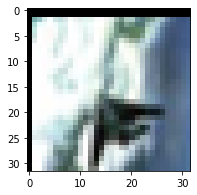

In [19]:
img_check = ((reduced_train_dataset[500][0] * std) + mean)
plt.figure(figsize = (3,3))
plt.imshow(img_check.permute(1,2,0))

### Visualize a few images

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

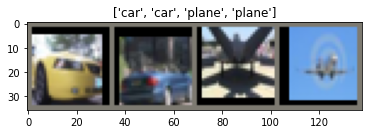

In [28]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=4, 
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 1.1 Write code (VGG 16) [3 points]

In [59]:
print('STEP 3: CREATE MODEL CLASS (VGG16)')


class VGG (nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.conv1_x = nn.Sequential(
            nn.Conv2d(3, 64, 3,1,1), # 32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,1,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 32 ->16
        )
        self.conv2_x = nn.Sequential(
            nn.Conv2d(64,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 16 -> 8
        )
        self.conv3_x = nn.Sequential(
            nn.Conv2d(128,256,3,1,1), # 8 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 8 -> 4
        )
        self.conv4_x = nn.Sequential(
            nn.Conv2d(256,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2,2)  # 4 -> 2
        )
        self.conv5_x = nn.Sequential(
            nn.Conv2d(512,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 2 -> 1
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512,3)
        )
    def forward(self, x):
        out = self.conv1_x(x)
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)
        out = self.fc3(out.flatten(1))
        return out
        
    


STEP 3: CREATE MODEL CLASS (VGG16)


In [60]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model = VGG()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  14724675


VGG(
  (conv1_x): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2_x): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3_x): Sequential(
    (0): Conv2d(128,

In [61]:
summary(model,(3,32,32),128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 64, 32, 32]           1,792
       BatchNorm2d-2          [128, 64, 32, 32]             128
              ReLU-3          [128, 64, 32, 32]               0
            Conv2d-4          [128, 64, 32, 32]          36,928
       BatchNorm2d-5          [128, 64, 32, 32]             128
              ReLU-6          [128, 64, 32, 32]               0
         MaxPool2d-7          [128, 64, 16, 16]               0
            Conv2d-8         [128, 128, 16, 16]          73,856
       BatchNorm2d-9         [128, 128, 16, 16]             256
             ReLU-10         [128, 128, 16, 16]               0
           Conv2d-11         [128, 128, 16, 16]         147,584
      BatchNorm2d-12         [128, 128, 16, 16]             256
             ReLU-13         [128, 128, 16, 16]               0
        MaxPool2d-14           [128, 12

In [62]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 1.2 Train the VGG 16 model and print test accuracy for every epochs [2 points]

In [63]:
print('STEP 7: TRAIN THE MODEL')
num_epochs = 20

#############
# CODE HERE #
#############

loss_train= []
loss_test = []
for epoch in range(1,num_epochs+1):
    start_time = time.time()
    
    model.train()
    loss_train_epoch = []
    # batch
    for idx, (x, y_true) in enumerate(train_loader):
        x, y_true = x.to(device) , y_true.to(device)
        
        optimizer.zero_grad()
        
        y_pred = model(x)
        loss = criterion(y_pred,y_true)
        
        loss.backward()
        optimizer.step()
        
        loss_train_epoch.append(loss)
    
    loss_train.append(sum(loss_train_epoch)/len(loss_train_epoch))
    
    # test 
    loss_test_epoch = []
    accuracy_test = []
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for idx , (x, y_true) in enumerate(test_loader):
            x, y_true = x.to(device) , y_true.to(device)
            
            y_pred = model(x)
            #loss calculation
            loss = criterion(y_pred,y_true)
            loss_test_epoch.append(loss)
            
            # accuracy calculation
            pred_label = torch.max(y_pred,1)[1]
            
            # data 개수
            total += y_true.size(0)
            # correct prediction
            correct += (pred_label == y_true).sum()
            
        accuracy = 100 * correct.item() / total
        loss_test.append(sum(loss_test_epoch)/len(loss_test_epoch))
    end_time = time.time()
    print('Epoch: {}. Train Loss: {}. Test Loss: {}. Test Accuracy: {: .2f}, Elapsed time: {:.3f}s'.format(epoch, loss_train[-1],loss_test[-1], accuracy,end_time - start_time))

STEP 7: TRAIN THE MODEL
Epoch: 1. Train Loss: 0.6502020359039307. Test Loss: 0.4987167716026306. Test Accuracy:  82.17, Elapsed time: 2.963s
Epoch: 2. Train Loss: 0.39276793599128723. Test Loss: 0.3205876648426056. Test Accuracy:  87.10, Elapsed time: 2.945s
Epoch: 3. Train Loss: 0.2927931249141693. Test Loss: 0.2622670531272888. Test Accuracy:  90.23, Elapsed time: 2.928s
Epoch: 4. Train Loss: 0.22830544412136078. Test Loss: 0.23156949877738953. Test Accuracy:  91.63, Elapsed time: 2.956s
Epoch: 5. Train Loss: 0.20240214467048645. Test Loss: 0.29338282346725464. Test Accuracy:  89.50, Elapsed time: 2.930s
Epoch: 6. Train Loss: 0.1568184494972229. Test Loss: 0.3099503219127655. Test Accuracy:  90.07, Elapsed time: 2.933s
Epoch: 7. Train Loss: 0.1289101094007492. Test Loss: 0.20593824982643127. Test Accuracy:  92.00, Elapsed time: 2.947s
Epoch: 8. Train Loss: 0.10347548127174377. Test Loss: 0.25660133361816406. Test Accuracy:  92.80, Elapsed time: 2.939s
Epoch: 9. Train Loss: 0.08471022

## 2. ResNet with PyTorch

### Implementing ResNet

> 1. **Dataset**
>> - The same dataset used for VGGNet
>
> 2. **Network architecture**
>> - 50-layer ResNet with **bottleneck blocks**. <br>
     Note. The initial convolution layer (i.e., conv1) is different from the one in the paper &<br>
     the initial max-pooling layer is removed (because the size of CIFAR-10 images is too small).
>> - ReLU activation.
>> - Strided convolution for down-sampling instead of max-pooling layer. <br>
     Note. Once down-sampled, a $1\times1$ convolution/stride 2 is applied to residual for expanding the channel of the residual.
>> - No dropout for simplicity.
>> - Batch-normalization after every convolution.
>>
>>
>> <table><tr>
>> <td> <img src="http://drive.google.com/uc?export=view&id=1l3rC40WnBXZBagFIuME48SPvcqVY-56Y" alt="no_image" style="width: 500px;"/> </td>
>> <td> <img src="http://drive.google.com/uc?export=view&id=1r92UcNqn6ZT5pOk3emEijjTKlWdAYvCk" alt="no_image" style="width: 300px;"/> </td>
>> </tr></table>
>>
>> <img src="http://drive.google.com/uc?export=view&id=1n0NYyWWbDBd9PHjNEs7AHpOhMci5q6qk" alt="no_image" style="width: 870px;"/>
>>
>> <font size="0.5"> Figures from <br> 
>> [1] https://www.codeproject.com/Articles/1248963/Deep-Learning-using-Python-plus-Keras-Chapter-Re  <br> 
>> [2] Rezende et al., *Signal Processing: Image Communication*, 2018. </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 15 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
> 

### 2.1 Implement ResNet50 and train it with the CIFAR 10 dataset [4 points] 

In [68]:
print('STEP 3: CREATE MODEL CLASS (ResNet-50)')

class bottleneck(nn.Module):
  # split into 1) first block, 2) downsample, 3) normal case!
    def __init__(self, bottleneck_dim, downsample = False, first_block= False):
        super(bottleneck,self).__init__()
        self.downsample = downsample
        self.first_block = first_block
        # 최초 블락은 featuremap size가 유지되며, input channel과 bottleneck_dim이 같다.
        if first_block == True:
            self.conv1 = nn.Sequential(
              nn.Conv2d(bottleneck_dim, bottleneck_dim, 1, 1),
              nn.BatchNorm2d(bottleneck_dim),
              nn.ReLU()
            )
            self.conv2 = nn.Sequential(
              nn.Conv2d(bottleneck_dim, bottleneck_dim, 3, 1 ,1),
              nn.BatchNorm2d(bottleneck_dim),
              nn.ReLU()
            )
            self.conv3 = nn.Sequential(
              nn.Conv2d(bottleneck_dim, 4*bottleneck_dim, 1,1),
              nn.BatchNorm2d(4*bottleneck_dim),
              nn.ReLU()
            )
            self.conv_res = nn.Sequential(
              nn.Conv2d(bottleneck_dim, 4*bottleneck_dim,1, 1),
              nn.BatchNorm2d(4*bottleneck_dim),
              nn.ReLU()
            )
        # bottleneck Block의 최초 Bottleneck: input의 channel # = 2 x bottleneck_dim, Downsampling with stride =2
        elif downsample == True:
            self.conv1 = nn.Sequential(
              nn.Conv2d(2*bottleneck_dim, bottleneck_dim, 1, 2),
              nn.BatchNorm2d(bottleneck_dim),
              nn.ReLU()
            )
            self.conv2 = nn.Sequential(
              nn.Conv2d(bottleneck_dim, bottleneck_dim, 3, 1 ,1),
              nn.BatchNorm2d(bottleneck_dim),
              nn.ReLU()
            )
            self.conv3 = nn.Sequential(
              nn.Conv2d(bottleneck_dim, 4*bottleneck_dim, 1,1),
              nn.BatchNorm2d(4*bottleneck_dim),
              nn.ReLU()
            )
            self.conv_res = nn.Sequential(
              nn.Conv2d(2*bottleneck_dim, 4*bottleneck_dim,1, 2),
              nn.BatchNorm2d(4*bottleneck_dim),
              nn.ReLU()
            )
        else:
            self.conv1 = nn.Sequential(
              nn.Conv2d(4*bottleneck_dim, bottleneck_dim, 1, 1),
              nn.BatchNorm2d(bottleneck_dim),
              nn.ReLU()
            )
            self.conv2 = nn.Sequential(
              nn.Conv2d(bottleneck_dim, bottleneck_dim, 3, 1 ,1),
              nn.BatchNorm2d(bottleneck_dim),
              nn.ReLU()
            )
            self.conv3 = nn.Sequential(
              nn.Conv2d(bottleneck_dim, 4*bottleneck_dim, 1,1),
              nn.BatchNorm2d(4*bottleneck_dim),
              nn.ReLU()
            )
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        # if channel expansion needed
        if self.downsample == True or self.first_block == True:
            shortcut =  self.conv_res(x)
        else:
            shortcut = x
        result = out + shortcut
        return result



class ResNet_50(nn.Module):
    def __init__(self):
        super(ResNet_50,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3,1,1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.conv2_x = nn.Sequential(
            bottleneck(64,False,first_block = True),
            bottleneck(64,False),
            bottleneck(64,False)
        )
        self.conv3_x = nn.Sequential(
            bottleneck(128,True),
            bottleneck(128,False),
            bottleneck(128,False),
            bottleneck(128,False)
        )
        self.conv4_x = nn.Sequential(
            bottleneck(256,True),
            bottleneck(256,False),
            bottleneck(256,False),
            bottleneck(256,False),
            bottleneck(256,False),
            bottleneck(256,False)
        )
        self.conv5_x = nn.Sequential(
          bottleneck(512,True),
          bottleneck(512,False),
          bottleneck(512,False)
        )
        self.fc3 = nn.Linear(2048, 3)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)
        out = nn.AvgPool2d(out.shape[2])(out) # GAP
        out = self.fc3(out.view(-1,2048))
        return out


    
print('STEP 4: INSTANTIATE MODEL CLASS')
#############
# CODE HERE #
#############
model = ResNet_50()
model.to(device)

STEP 3: CREATE MODEL CLASS (ResNet-50)
STEP 4: INSTANTIATE MODEL CLASS


ResNet_50(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2_x): Sequential(
    (0): bottleneck(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv3): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv_res): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [74]:
print('STEP 3: CREATE MODEL CLASS (ResNet-50)')

class bottleneck(nn.Module):
  # split into 1) first block, 2) downsample, 3) normal case!
    def __init__(self, bottleneck_dim, downsample = False, first_block= False):
        super(bottleneck,self).__init__()
        self.downsample = downsample
        self.first_block = first_block
        # 최초 블락은 featuremap size가 유지되며, input channel과 bottleneck_dim이 같다.
        if first_block == True:
            self.conv1 = nn.Sequential(
              nn.Conv2d(bottleneck_dim, bottleneck_dim, 1, 1),
              nn.BatchNorm2d(bottleneck_dim),
              nn.ReLU()
            )
            self.conv2 = nn.Sequential(
              nn.Conv2d(bottleneck_dim, bottleneck_dim, 3, 1 ,1),
              nn.BatchNorm2d(bottleneck_dim),
              nn.ReLU()
            )
            self.conv3 = nn.Sequential(
              nn.Conv2d(bottleneck_dim, 4*bottleneck_dim, 1,1),
              nn.BatchNorm2d(4*bottleneck_dim),
              nn.ReLU()
            )
            self.conv_res = nn.Sequential(
              nn.Conv2d(bottleneck_dim, 4*bottleneck_dim,1, 1),
              nn.BatchNorm2d(4*bottleneck_dim),
              nn.ReLU()
            )
        # bottleneck Block의 최초 Bottleneck: input의 channel # = 2 x bottleneck_dim, Downsampling with stride =2
        elif downsample == True:
            self.conv1 = nn.Sequential(
              nn.Conv2d(2*bottleneck_dim, bottleneck_dim, 1, 2),
              nn.BatchNorm2d(bottleneck_dim),
              nn.ReLU()
            )
            self.conv2 = nn.Sequential(
              nn.Conv2d(bottleneck_dim, bottleneck_dim, 3, 1 ,1),
              nn.BatchNorm2d(bottleneck_dim),
              nn.ReLU()
            )
            self.conv3 = nn.Sequential(
              nn.Conv2d(bottleneck_dim, 4*bottleneck_dim, 1,1),
              nn.BatchNorm2d(4*bottleneck_dim),
              nn.ReLU()
            )
            self.conv_res = nn.Sequential(
              nn.Conv2d(2*bottleneck_dim, 4*bottleneck_dim,1, 2),
              nn.BatchNorm2d(4*bottleneck_dim),
              nn.ReLU()
            )
        else:
            self.conv1 = nn.Sequential(
              nn.Conv2d(4*bottleneck_dim, bottleneck_dim, 1, 1),
              nn.BatchNorm2d(bottleneck_dim),
              nn.ReLU()
            )
            self.conv2 = nn.Sequential(
              nn.Conv2d(bottleneck_dim, bottleneck_dim, 3, 1 ,1),
              nn.BatchNorm2d(bottleneck_dim),
              nn.ReLU()
            )
            self.conv3 = nn.Sequential(
              nn.Conv2d(bottleneck_dim, 4*bottleneck_dim, 1,1),
              nn.BatchNorm2d(4*bottleneck_dim),
              nn.ReLU()
            )
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        # if channel expansion needed
        if self.downsample == True or self.first_block == True:
            shortcut =  self.conv_res(x)
        else:
            shortcut = x
        out += shortcut
        return out



class ResNet_50(nn.Module):
    def __init__(self):
        super(ResNet_50,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3,1,1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.conv2_x = nn.Sequential(
            bottleneck(64,False,first_block = True),
            bottleneck(64,False),
            bottleneck(64,False)
        )
        self.conv3_x = nn.Sequential(
            bottleneck(128,True),
            bottleneck(128,False),
            bottleneck(128,False),
            bottleneck(128,False)
        )
        self.conv4_x = nn.Sequential(
            bottleneck(256,True),
            bottleneck(256,False),
            bottleneck(256,False),
            bottleneck(256,False),
            bottleneck(256,False),
            bottleneck(256,False)
        )
        self.conv5_x = nn.Sequential(
          bottleneck(512,True),
          bottleneck(512,False),
          bottleneck(512,False)
        )
        self.fc3 = nn.Linear(2048, 3)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)
        out = nn.AvgPool2d(out.shape[2])(out) # GAP
        out = self.fc3(out.view(-1,2048))
        return out


    
print('STEP 4: INSTANTIATE MODEL CLASS')
#############
# CODE HERE #
#############
model = ResNet_50()
model.to(device)

STEP 3: CREATE MODEL CLASS (ResNet-50)
STEP 4: INSTANTIATE MODEL CLASS


ResNet_50(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2_x): Sequential(
    (0): bottleneck(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv3): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv_res): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [75]:
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           4,160
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,640
      BatchNorm2d-11          [-1, 256, 32, 32]             512
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]          16,640
      BatchNorm2d-14          [-1, 256,

### 2.2 Print test accuracy for every epochs. [1 points]

In [70]:

print('STEP 5: INSTANTIATE LOSS CLASS')
#############
# CODE HERE #
#############
criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')
#############
# CODE HERE #
#############

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

print('STEP 7: TRAIN THE MODEL')
#############
# CODE HERE #
#############

num_epochs = 15


loss_train= []
loss_test = []
for epoch in range(1,num_epochs+1):
    start_time = time.time()
    
    model.train()
    loss_train_epoch = []
    # batch
    for idx, (x, y_true) in enumerate(train_loader):
        x, y_true = x.to(device) , y_true.to(device)
        
        optimizer.zero_grad()
        
        y_pred = model(x)
        loss = criterion(y_pred,y_true)
        
        loss.backward()
        optimizer.step()
        
        loss_train_epoch.append(loss)
    
    loss_train.append(sum(loss_train_epoch)/len(loss_train_epoch))
    
    # test 
    loss_test_epoch = []
    accuracy_test = []
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for idx , (x, y_true) in enumerate(test_loader):
            x, y_true = x.to(device) , y_true.to(device)
            
            y_pred = model(x)
            #loss calculation
            loss = criterion(y_pred,y_true)
            loss_test_epoch.append(loss)
            
            # accuracy calculation
            pred_label = torch.max(y_pred,1)[1]
            
            # data 개수
            total += y_true.size(0)
            # correct prediction
            correct += (pred_label == y_true).sum()
            
        accuracy = 100 * correct.item() / total
        loss_test.append(sum(loss_test_epoch)/len(loss_test_epoch))
    end_time = time.time()
    print('Epoch: {}. Train Loss: {}. Test Loss: {}. Test Accuracy: {}. Elapsed time: {:.2f}s'.format(epoch, loss_train[-1],loss_test[-1], accuracy, end_time-start_time))

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS
STEP 7: TRAIN THE MODEL
Epoch: 1. Train Loss: 1.4698764085769653. Test Loss: 0.948887825012207. Test Accuracy: 59.46666666666667. Elapsed time: 15.52s
Epoch: 2. Train Loss: 0.7047858834266663. Test Loss: 1.6508234739303589. Test Accuracy: 73.73333333333333. Elapsed time: 15.55s
Epoch: 3. Train Loss: 0.6906009912490845. Test Loss: 0.5947518944740295. Test Accuracy: 76.63333333333334. Elapsed time: 15.61s
Epoch: 4. Train Loss: 0.6256542801856995. Test Loss: 0.6911194920539856. Test Accuracy: 70.03333333333333. Elapsed time: 15.68s
Epoch: 5. Train Loss: 0.5104503035545349. Test Loss: 1.1539313793182373. Test Accuracy: 70.3. Elapsed time: 15.73s
Epoch: 6. Train Loss: 0.5120373964309692. Test Loss: 0.38970834016799927. Test Accuracy: 84.1. Elapsed time: 15.78s
Epoch: 7. Train Loss: 0.4451254904270172. Test Loss: 0.38346630334854126. Test Accuracy: 84.6. Elapsed time: 15.80s
Epoch: 8. Train Loss: 0.3706657886505127. Test Loss